In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

from konlpy.tag import Okt
from konlpy.tag import Twitter
from soynlp.tokenizer import MaxScoreTokenizer
from soynlp.normalizer import *
import re
import sentencepiece as spm # 가장 성능이 좋았음
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
#import wandb
#from wandb.keras import WandbCallback

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


# 데이터

In [2]:
train_data_path ="final_data_preprocessed_241207.csv"
train_data = pd.read_csv(train_data_path)
train_data.head(10)

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,협박 대화,길동 경찰서입니다. 9시 40분 마트에 폭발물을 설치할 거다. 네? 똑바로 들어 한...
2,2,기타 괴롭힘 대화,너 되게 귀여운 거 알지? 나보다 작은 남자는 첨 봤어. 그만해. 너희들 놀리는 거...
3,3,갈취 대화,어이 거기 예? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아 보인다? 얘 돈...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
5,5,직장 내 괴롭힘 대화,나 이틀 뒤에 가나다 음식점 예약 좀 해줘. 저녁 7시로. 가나다 음식점이요.? 응...
6,6,기타 괴롭힘 대화,35번 손님 아이스커피 두 잔 나왔습니다 아이스커피? 네 맛있게 드세요 저기요 아가...
7,7,기타 괴롭힘 대화,경비 아저씨 내 차에 경고장 붙였어요? 내가 여기 몇 년째 사는데 아직도 내 차인 ...
8,8,기타 괴롭힘 대화,이거 할인된다면서요 확인해 보겠습니다 아까 저 사람은 할인해 주던데 네 저 손님은 ...
9,9,갈취 대화,자네 세금계산서 보내준 거 메일이랑 수치가 다르던데? 그게. 얼마나 해먹었어? 괜찮...


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4960 non-null   int64 
 1   class         4960 non-null   object
 2   conversation  4960 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.4+ KB


In [4]:
train_data['class'].value_counts()

기타 괴롭힘 대화      1094
일반 대화          1010
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
Name: class, dtype: int64

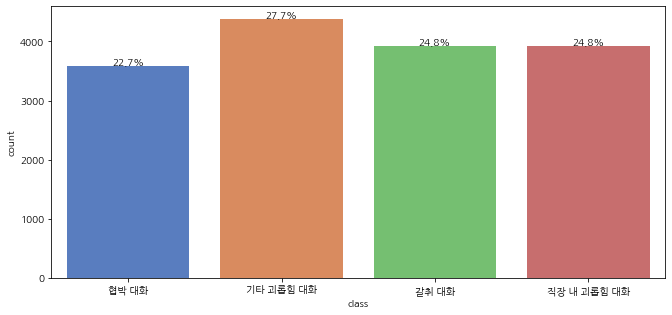

In [98]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11, 5)

# plot 그림
sns.countplot(x='class', data=train_data, palette='muted') 

# 퍼센트 표기
total = len(train_data['class'])
for p in axe.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axe.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

***클래스간의 약간의 차이가 있기는 하나, 큰 차이를 보이지 않음***

In [99]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

class_dict = {}
for idx, class_name in enumerate(CLASS_NAMES):
    class_dict[class_name] = idx

train_data['class'] = train_data['class'].apply(lambda s: class_dict[s])

corpus = train_data["conversation"]


In [100]:
corpus.head()

0    지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1    [MASK] 지금 너 [MASK] 스스로를 죽여달라고 애원하는 것인가 [MASK] ...
2    지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 해 거면 혼자...
3    지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 곧 거면...
4    길동 경찰서입니다. 9시 40분 마트에 폭발물을 설치할 거다. 네? 똑바로 들어 한...
Name: conversation, dtype: object

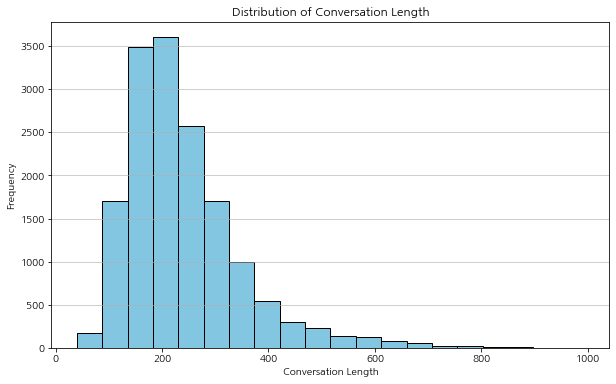

In [101]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 대화의 길이 계산
# train_data['conversation_length'] = train_data['conversation'].apply(lambda x: len(x))
# Replace NaN or None values with an empty string and ensure all values are strings
train_data['conversation_length'] = train_data['conversation'].fillna("").astype(str).apply(len)

# Seaborn의 muted 팔레트와 비슷한 색상 생성
custom_palette = sns.color_palette("muted")

# 대화 길이 시각화
plt.figure(figsize=(10, 6))
plt.hist(train_data['conversation_length'], bins=20, color=custom_palette[9], edgecolor='black')  
plt.xlabel('Conversation Length')
plt.ylabel('Frequency')
plt.title('Distribution of Conversation Length')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [35]:
# train_data.head()

In [102]:
train_data['conversation_length']

0        235
1        253
2        222
3        237
4        191
        ... 
15795    234
15796    148
15797    169
15798    145
15799    151
Name: conversation_length, Length: 15800, dtype: int64

In [103]:
np.min(train_data['conversation_length'])

40

In [104]:
np.max(train_data['conversation_length'])

993

문장의 최단 길이: 40
문장의 최장 길이: 993
문장의 평균 길이: 238


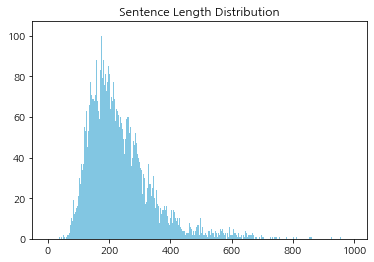

In [105]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['conversation_length']:
    length = sen
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['conversation_length']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['conversation_length']:
    sentence_length[sen-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0, color = custom_palette[9])
plt.title("Sentence Length Distribution")
plt.show()

# Augmentation

In [40]:
!wget https://github.com/catSirup/KorEDA/blob/master/wordnet.pickle

--2024-12-08 03:32:53--  https://github.com/catSirup/KorEDA/blob/master/wordnet.pickle
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘wordnet.pickle.12’

wordnet.pickle.12       [ <=>                ] 285.11K  --.-KB/s    in 0.03s   

2024-12-08 03:32:54 (11.1 MB/s) - ‘wordnet.pickle.12’ saved [291953]



In [41]:
!pwd

/aiffel/aiffel/dktc


In [42]:
import random
import pickle
import re
import numpy as np


# Num_Aug = 7
Num_Aug = 4

wordnet = {}
with open("wordnet.pickle", "rb") as f:
    wordnet = pickle.load(f)

# 한글만 남기고 나머지 제거
def get_only_hangul(line):
    parseText = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', line)
    return parseText

# Random masking insertion (BertAugmentation)
def random_masking_insertion(words, n):
    new_words = words.copy()
    mask_token = "[MASK]"
    for _ in range(n):
        random_idx = random.randint(0, len(new_words))
        new_words.insert(random_idx, mask_token)
    return new_words


# Adverb augmentation
def adverb_augmentation(sentence):
    adverbs = [
    "매우", "조금", "아주", "정말", "굉장히", "적당히", "적절하게",
    "무척", "엄청", "대단히", "자주", "가끔", "드물게", "항상",
    "매일", "곧", "바로", "이미", "아직", "현재", "최근에",
    "전혀", "별로", "거의", "결코", "빠르게", "천천히", "조용히", "신중히"
]
    words = sentence.split()
    
     # Check if the sentence has enough words
    if not words:
        print("Warning: Sentence has no words!")
        return sentence  # Return the original sentence if it's empty
    
    random_adverb = random.choice(adverbs)
    random_idx = random.randint(0, len(words) - 1)

    words.insert(random_idx, random_adverb)
    augmented_sentence = " ".join(words)
    #print(augmented_sentence)
    return augmented_sentence


# Random insertion
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        if len(new_words) > 1:
            random_word = new_words[random.randint(0, len(new_words) - 1)]
            synonyms = get_synonyms(random_word)
        else:
            return
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words) - 1)
    new_words.insert(random_idx, random_synonym)

    
# AEDA (Random punctuation insertion)
def aeda(sentence, punc_list=None):
    if punc_list is None:
        punc_list = ['.', ',', '!', '?']
    words = sentence.split()
    num_punc = max(1, len(words) // 3)
    for _ in range(num_punc):
        idx = random.randint(0, len(words) - 1)
        words.insert(idx, random.choice(punc_list))
    return " ".join(words)


# Synonym replacement (기존 기능)
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if synonyms:  # 동의어가 있을 때만 실행
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def get_synonyms(word):
    synonyms = []
    try:
        for syn in wordnet[word]:
            synonyms.extend(syn)
    except KeyError:
        pass
    return synonyms


# Random swap
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    if len(new_words) < 2:
        return new_words
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words


## 단어 끊어읽기
def get_only_hangul(line):
    # Keep both Korean, English, and numbers along with spaces
    parseText = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]', '', line)
    return parseText

# EDA (Exploratory Data Augmentation)
def apply_eda(sentence, num_aug = Num_Aug):
    augmented_sentences = []
    
    # 1. Add the original sentence as the first augmented sentence
    augmented_sentences.append(sentence)

    cleaned_sentence = get_only_hangul(sentence)
    words = cleaned_sentence.split()

    # If the sentence is too short, return the original sentence multiple times
    if len(words) < 2:
        return [sentence] * num_aug

    # Calculate numbers for augmentation
    n_sr = max(1, len(words) // 10)
    n_ri = max(1, len(words) // 10)
    n_rs = max(1, len(words) // 10)


    try:
        # 2. Random Masking
        rm_result = " ".join(random_masking_insertion(words, n_sr))
        if rm_result.strip():
            augmented_sentences.append(rm_result)
    except Exception as e:
        print(f"Error in Random Masking: {e}")
        
    try:
        # 3. Random Insertion
        ri_result = " ".join(random_insertion(words, n_ri))
        if ri_result.strip():
            augmented_sentences.append(ri_result)
    except Exception as e:
        print(f"Error in Random Insertion: {e}")
        
    try:
        # 4. Adverb Augmentation
        ad_result = adverb_augmentation(sentence)
        # print(f"Adverb Augmentation: {ad_result}")  # Debugging
        if ad_result.strip():
            augmented_sentences.append(ad_result)
    except Exception as e:
        print(f"Error in Adverb Augmentation: {e}")
        

#     try:
#         # 5. AEDA
#         aeda_result = aeda(sentence)
#         if aeda_result.strip():
#             augmented_sentences.append(aeda_result)
#     except Exception as e:
#         print(f"Error in AEDA: {e}")
        
#     try:
#         # 6. Synonym Replacement
#         sr_result = " ".join(synonym_replacement(words, n_sr))
#         if sr_result.strip():
#             augmented_sentences.append(sr_result)
#     except Exception as e:
#         print(f"Error in Synonym Replacement: {e}")


#     try:
#         # 7. Random Swap
#         rs_result = " ".join(random_swap(words, n_rs))
#         if rs_result.strip():
#             augmented_sentences.append(rs_result)
#     except Exception as e:
#         print(f"Error in Random Swap: {e}")   
        
        
    # Fill with original sentence if there are fewer than num_aug sentences
    while len(augmented_sentences) < num_aug:
        augmented_sentences.append(sentence)

    return augmented_sentences[:num_aug]


# Testing the function
sentence = "이 문장은 데이터 증강을 테스트합니다."
augmented_sentences = apply_eda(sentence, num_aug = Num_Aug)
for i, aug_sentence in enumerate(augmented_sentences):
    print(f"Augmented Sentence {i + 1}: {aug_sentence}")


Augmented Sentence 1: 이 문장은 데이터 증강을 테스트합니다.
Augmented Sentence 2: 이 문장은 [MASK] 데이터 증강을 테스트합니다
Augmented Sentence 3: 이 문장은 이 데이터 증강을 테스트합니다
Augmented Sentence 4: 이 문장은 이미 데이터 증강을 테스트합니다.


In [43]:
# Ensure all conversations are strings and handle NaN
train_data['conversation'] = train_data['conversation'].fillna("").astype(str)

class_ls = []
augcon_ls = []

for i in range(len(train_data['conversation'])):
    class_ = train_data['class'][i]
    num_aug = Num_Aug  # Number of augmentations

    # Debugging: Print the current sentence
    sentence = train_data['conversation'][i]
    print(f"Processing sentence at index {i}: {sentence}")

    # Apply EDA
    try:
        augcon = apply_eda(sentence, num_aug=num_aug)
    except Exception as e:
        print(f"Error in EDA at index {i}: {e}")
        continue

    if not augcon:  # Handle if EDA returns an empty list
        print(f"Warning: EDA returned an empty list for iteration {i}")
        continue

    # Append augmented data
    for j in range(num_aug):
        class_ls.append(int(class_))
        augcon_ls.append(augcon[j])

# Create DataFrame with augmented data
augmented_data = pd.DataFrame({"class": class_ls, "conversation": augcon_ls})

Processing sentence at index 0: 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 네가 선택해. 네가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴 거야. 선택 못하겠습니다. 한 번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.
Processing sentence at index 1: 길동 경찰서입니다. 9시 40분 마트에 폭발물을 설치할 거다. 네? 똑바로 들어 한 번만 더 얘기한다. 장난전화 걸지 마시죠. 9시 40분 마트에 폭발물이 터지면 다 죽는 거야. 장난전화는 업무방해죄에 해당됩니다. 판단은 너에게 달려있다. 길동 경찰서에도 폭발물 터지면 꽤나 재미있겠지. 선생님 진정하세요. 난 이야기했어. 경고했다는 말이야.
Processing sentence at index 2: 너 되게 귀여운 거 알지? 나보다 작은 남자는 첨 봤어. 그만해. 너희들 놀리는 거 재미없어. 지영아 네가 키 160이지? 그럼 재는 160도 안되는 거네? 너 군대도 안 가고 좋겠다. 너희들이 나 작은데 보태준 거 있냐? 난쟁이들도 장가가고 하던데. 너도 희망을 가져봐 더 이상 하지 마라. 그 키 크는 수술도 있다잖아? 너네 엄마는 그거 안 해주디? 나라 해줬어. 저 키로 어찌 살아. 제발 그만 괴롭히라고!
Processing sentence at index 3: 어이 거기 예? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽는다 오늘 피시방 콜? 콜. 마지막 기회다. 있는 거 다 내놔 정말 없어요
Processing sentence at index 4: 저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 발라보실래요? 아 진짜요? 안

In [44]:
len(class_ls)

22472

In [50]:
aug_data = pd.DataFrame([class_ls, augcon_ls],
                  index=['class','conversation'],
                 columns=[x for x in range(len(class_ls))])
aug_data = aug_data.transpose()

In [51]:
aug_data

,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,0,[MASK] 지금 너 스스로를 [MASK] 죽여달라고 애원하는 것인가 아닙니다 죄송...
2,0,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
3,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
4,0,길동 경찰서입니다. 9시 40분 마트에 폭발물을 설치할 거다. 네? 똑바로 들어 한...
...,...,...
22467,4,탱크로리 차량이 건물로 엄청 돌진했어요. 다친 사람은 없나요? 10명 정도가 쓰러졌...
22468,4,"지금 양재역 지나고 있는 405번 버스 안인데요, 네 말씀 하세요. 버스 안에서 할..."
22469,4,지금 양재역 지나고 [MASK] 있는 405번 버스 안인데요 네 말씀 하세요 버스 ...
22470,4,지금 양재역 안 지나고 있는 405번 버스 안인데요 버 네 말씀 하세요 버스 안에서...


In [52]:
reverse_class_dict = {v: k for k, v in class_dict.items()}

In [53]:
# ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']
reverse_class_dict = {
    0: '협박 대화',
    1: '갈취 대화',
    2: '직장 내 괴롭힘 대화',
    3: '기타 괴롭힘 대화',
    4: '일반 대화'
}

In [54]:
aug_data['class'] = aug_data['class'].apply(lambda num: reverse_class_dict[num])

In [55]:
# "final_data_emergency_added_preprocessed_241208.csv" data 사용
output_csv_path = 'final_data_emergency_added_preprocessed_DA_top3_241208.csv'

aug_data.to_csv(output_csv_path, index=False , encoding='utf-8-sig')

print(f"'aug_data' has been successfully saved to {output_csv_path}")

'aug_data' has been successfully saved to final_data_emergency_added_preprocessed_DA_top3_241208.csv
